<a href="https://colab.research.google.com/github/ozyinc/ANNADL-project/blob/master/challenge3ImageAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Run this cell only if you are using Colab with Drive
# Run each time you initialize a machine
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/My Drive/Datasets/VQA_Dataset.zip' > /dev/null

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace Images/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import PIL
import json
import glob

from os import path
# set seed
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)
import numpy as np
import tensorflow as tf
from tensorflow import keras
import PIL
import json
import glob

img_pre = keras.preprocessing.image

from os import path

DIR = path.abspath(path.curdir)

# set seed
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)


In [35]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):
    """
      CustomDataset inheriting from tf.keras.utils.Sequence.

      3 main methods:
        - __init__: save dataset params like directory, filenames..
        - __len__: return the total number of samples in the dataset
        - __getitem__: return a sample from the dataset (image, question, answer)

      Note:
        - the custom dataset return a single sample from the dataset. Then, we use
          a tf.data.Dataset object to group samples into batches.
        - in this case we have a different structure of the dataset in memory.
          We have all the images in the same folder and the training and validation splits
          are defined in text files.

    """

    def __init__(self, which_subset, img_generator=None,
                 preprocessing_function=None, out_shape=[256, 256], validation_split=0.2):
                
        with open(path.join(DIR, "train_questions_annotations.json")) as file:
            loaded = json.load(file).values()
            train_questions = [x["question"] for x in loaded]
            train_images = [x["image_id"] for x in loaded]
            train_answers = [x["answer"] for x in loaded]
        train_images = list(dict.fromkeys(train_images))

        self.train_images = train_images
        self.img_generator = img_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.train_images)

    def __getitem__(self, index):
        img = Image.open(path.join("./Images", self.train_images[index] + ".png")).convert("RGB")
        img_arr = np.array(img)

        if self.preprocessing_function:
            img_arr = self.preprocessing_function(img_arr)
        img_arr = np.expand_dims(img_arr, axis=0)
        img_arr = img_arr.astype('float64')
        img_arr *= 1./255
        img_arr -= .5
        return img_arr, img_arr

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_gen = ImageDataGenerator()
dataset = CustomDataset('training', img_generator=train_data_gen)
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 400, 700, 3], [None, 400, 700, 3]))
train_dataset.repeat()

<RepeatDataset shapes: ((None, 400, 700, 3), (None, 400, 700, 3)), types: (tf.float32, tf.float32)>

In [37]:
# Create Model
# ------------

def create_model(depth, start_f, dynamic_input_shape = False):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.experimental.preprocessing.Resizing(400, 800))
    
    # Encoder
    # -------
    for i in range(depth):
        
        if i == 0:
            if dynamic_input_shape:
                input_shape = [None, None, 3]
            else:
                input_shape = [400, 800, 3]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2

    # Bottleneck
    model.add(tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.ReLU())
    
    start_f = start_f // 2
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=1,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='sigmoid'))
    
    model.add(tf.keras.layers.experimental.preprocessing.Resizing(400, 700))
    
    return model

In [55]:
import keras
from keras import layers

def create_leos_model():
    input_img = keras.Input(shape=(400, 700, 3))

    resized = layers.experimental.preprocessing.Resizing(400, 800)(input_img)

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(resized)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # We don't use this anymore since it appears that we get better results
    # encoded = layers.Dense(1000)(encoded)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    resized = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    decoded = layers.experimental.preprocessing.Resizing(400, 700)(resized)

    return keras.Model(input_img, decoded)

# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.MeanSquaredError()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

autoencoder = create_leos_model() # achieved 0.5 accuracy
#autoencoder = create_model(depth=5, start_f=8) # achieved 0.02 accuracy

# Compile Model
autoencoder.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [56]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 400, 700, 3)]     0         
_________________________________________________________________
resizing_8 (Resizing)        (None, 400, 800, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 400, 800, 8)       224       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 200, 400, 8)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 200, 400, 16)      1168      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 100, 200, 16)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 100, 200, 32)      4640

In [57]:
autoencoder.fit(x=train_dataset,
                batch_size=16,
                steps_per_epoch=58831/16,
                epochs=50,
                shuffle=True)

Epoch 1/50
3676/3676 [==============================] - 85s 23ms/step - loss: 0.0631 - accuracy: 0.6191
Epoch 2/50
3676/3676 [==============================] - 84s 23ms/step - loss: 0.0551 - accuracy: 0.6605
Epoch 3/50
3676/3676 [==============================] - 83s 23ms/step - loss: 0.0550 - accuracy: 0.6545
Epoch 4/50
3676/3676 [==============================] - 84s 23ms/step - loss: 0.0546 - accuracy: 0.6865
Epoch 5/50
3676/3676 [==============================] - 84s 23ms/step - loss: 0.0542 - accuracy: 0.6943
Epoch 6/50
3676/3676 [==============================] - 84s 23ms/step - loss: 0.0545 - accuracy: 0.6947
Epoch 7/50
3676/3676 [==============================] - 84s 23ms/step - loss: 0.0552 - accuracy: 0.6835
Epoch 8/50
3676/3676 [==============================] - 69s 19ms/step - loss: 0.0554 - accuracy: 0.6951


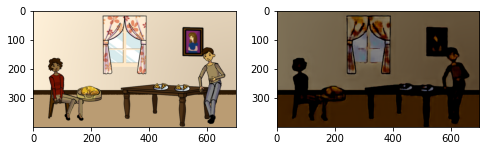

In [67]:
# Do a random predict()

import random

index = random.randint(1,1000)

try:
  img = Image.open(path.join("./Images", str(index) + ".png")).convert("RGB")
  img_arr = np.array(img)
  img_arr = np.expand_dims(img_arr, axis=0)

  img_arr = img_arr.astype('float64')
  img_arr *= 1./255
  img_arr -= .5

  out = autoencoder.predict(img_arr)
  out = out[0, :, :, :]
  #out += .5 # since we are using sigmoid as output (so range 0-1) we don't have to sum .5
  out *= 255 

  import matplotlib.pyplot as plt
  from PIL import Image

  fig, ax = plt.subplots(1, 2, figsize=(8, 8))
  fig.show()

  ax[0].imshow(np.uint8(img))
  ax[1].imshow(np.uint8(out))

  fig.canvas.draw()
except:
  pass

In [68]:
# Save the weights
!mkdir ./saved_encoder
autoencoder.save('./saved_encoder')
!zip -o -r saved_encoder.zip ./saved_encoder

INFO:tensorflow:Assets written to: ./saved_encoder/assets
  adding: saved_encoder/ (stored 0%)
  adding: saved_encoder/saved_model.pb (deflated 90%)
  adding: saved_encoder/variables/ (stored 0%)
  adding: saved_encoder/variables/variables.index (deflated 72%)
  adding: saved_encoder/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: saved_encoder/assets/ (stored 0%)
